# CIFAR-10 Classification with AKOrN (Artificial Kuramoto Oscillator Networks)

This notebook demonstrates how to train an AKOrN model for CIFAR-10 image classification.
AKOrN is based on the dynamics of Kuramoto oscillators and provides an alternative to traditional neural networks.

## References
- Miyato et al., "Artificial Kuramoto Oscillatory Neurons", ICLR 2025

## 1. Setup and Imports

In [ ]:
import os
import sys

%sys.path.append("/work/gj26/b20109/akorn/source")

import time
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

# Add source directory to path
#sys.path.append('source')

from models.classification.knet import AKOrN
from data.augs import augmentation_strong
from training_utils import save_checkpoint, save_model
from utils import str2bool

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Imports completed successfully!")

ModuleNotFoundError: No module named 'models'

In [4]:
sys.path

['/usr/lib/python312.zip',
 '/usr/lib/python3.12',
 '/usr/lib/python3.12/lib-dynload',
 '',
 '/work/gj26/b20109/.local/lib/python3.12/site-packages',
 '/usr/local/lib/python3.12/dist-packages',
 '/usr/local/lib/python3.12/dist-packages/nvfuser-0.2.23a0+6627725-py3.12-linux-aarch64.egg',
 '/usr/local/lib/python3.12/dist-packages/lightning_thunder-0.2.0.dev0-py3.12.egg',
 '/usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg',
 '/usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg',
 '/usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg',
 '/usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg',
 '/workspace/src',
 '/usr/lib/python3/dist-packages',
 '/work/gj25/b20109/akorn/source',
 '/tmp/546289.7250/tmpu89d2pm6',
 'source',
 '/work/gj26/b20109/akorn/source',
 'source',
 '/work/gj26/b20109/akorn/source',
 'source']

In [3]:
!pwd

/workspace


## 2. Configuration and Hyperparameters

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Training configuration
config = {
    # Data
    'batch_size': 128,
    'num_workers': 4,
    'num_classes': 10,
    
    # Model architecture
    'n': 2,              # Oscillator dimension (2D for complex oscillators)
    'ch': 64,            # Base number of channels
    'L': 3,              # Number of layers
    'T': 3,              # Number of time steps per layer
    'gamma': 1.0,        # Integration step size
    'J': 'conv',         # Connectivity type ('conv' or 'attn')
    'ksizes': [9, 7, 5], # Kernel sizes for each layer
    'ro_ksize': 3,       # Readout kernel size
    'ro_N': 2,           # Readout N parameter
    'norm': 'bn',        # Normalization type
    'c_norm': 'gn',      # C normalization type
    'use_omega': True,   # Use natural frequencies
    'init_omg': 1.0,     # Initial omega value
    'global_omg': True,  # Global omega parameter
    'learn_omg': True,   # Learn omega parameters
    'ensemble': 1,       # Ensemble size
    
    # Training
    'epochs': 100,
    'lr': 1e-4,
    'weight_decay': 0.0,
    'warmup_epochs': 5,
    
    # Logging
    'log_interval': 100,
    'eval_interval': 5,
    'save_interval': 20,
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Using device: cpu
Configuration:
  batch_size: 128
  num_workers: 4
  num_classes: 10
  n: 2
  ch: 64
  L: 3
  T: 3
  gamma: 1.0
  J: conv
  ksizes: [9, 7, 5]
  ro_ksize: 3
  ro_N: 2
  norm: bn
  c_norm: gn
  use_omega: True
  init_omg: 1.0
  global_omg: True
  learn_omg: True
  ensemble: 1
  epochs: 100
  lr: 0.0001
  weight_decay: 0.0
  warmup_epochs: 5
  log_interval: 100
  eval_interval: 5
  save_interval: 20


## 3. Data Loading and Preprocessing

In [3]:
# Data transforms
transform_train = augmentation_strong(imsize=32)
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets
train_dataset = CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform_train
)

test_dataset = CIFAR10(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform_test
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config['batch_size'], 
    shuffle=True, 
    num_workers=config['num_workers'],
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config['batch_size'], 
    shuffle=False, 
    num_workers=config['num_workers'],
    pin_memory=True
)

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {classes}")

Training samples: 50000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## 4. Data Visualization

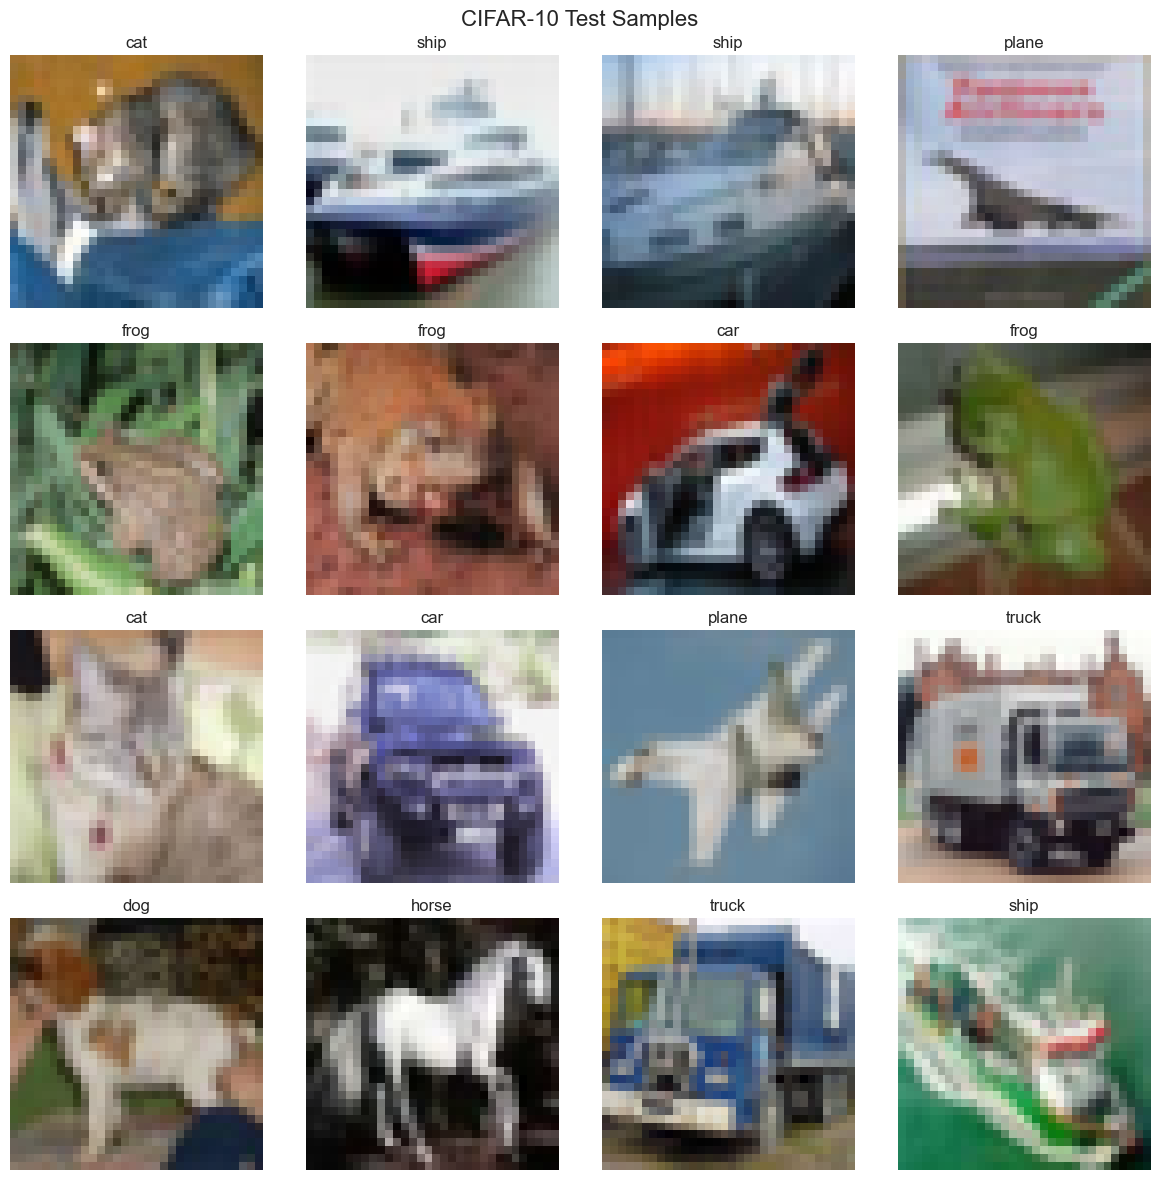

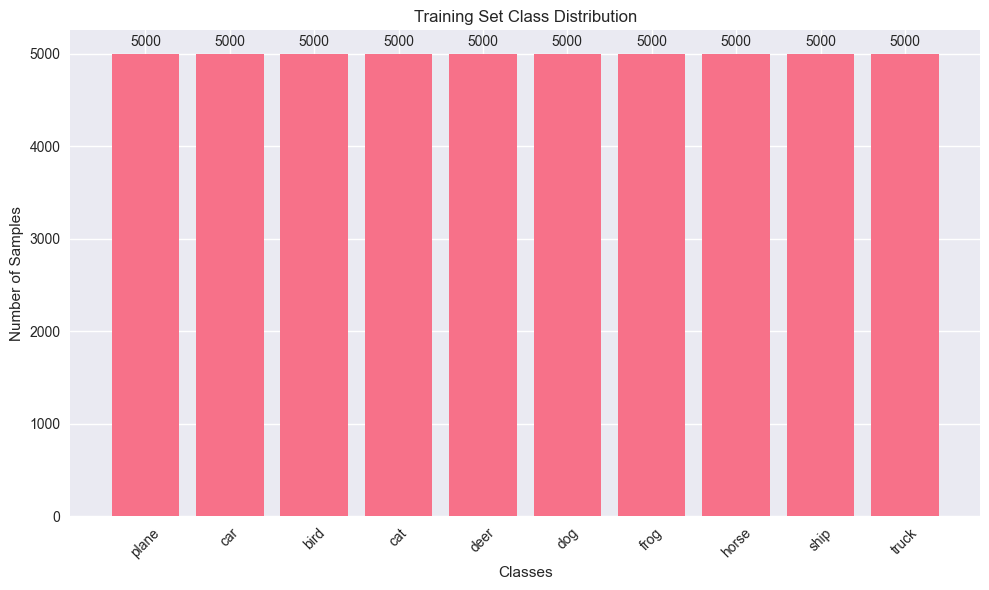

In [4]:
# Function to visualize samples
def visualize_samples(dataset, num_samples=16, title="CIFAR-10 Samples"):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_samples):
        img, label = dataset[i]
        
        # Convert tensor to numpy and transpose for visualization
        if isinstance(img, torch.Tensor):
            img_np = img.permute(1, 2, 0).numpy()
            # Denormalize if needed
            img_np = np.clip(img_np, 0, 1)
        else:
            img_np = np.array(img) / 255.0
        
        ax = axes[i // 4, i % 4]
        ax.imshow(img_np)
        ax.set_title(f'{classes[label]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
visualize_samples(test_dataset, title="CIFAR-10 Test Samples")

# Plot class distribution
def plot_class_distribution(dataset, title="Class Distribution"):
    labels = [dataset[i][1] for i in range(len(dataset))]
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar([classes[i] for i in unique], counts)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                f'{count}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, "Training Set Class Distribution")

## 5. Model Definition

In [5]:
# Create AKOrN model
model = AKOrN(
    n=config['n'],
    ch=config['ch'],
    out_classes=config['num_classes'],
    L=config['L'],
    T=config['T'],
    J=config['J'],
    ksizes=config['ksizes'],
    ro_ksize=config['ro_ksize'],
    ro_N=config['ro_N'],
    norm=config['norm'],
    c_norm=config['c_norm'],
    gamma=config['gamma'],
    use_omega=config['use_omega'],
    init_omg=config['init_omg'],
    global_omg=config['global_omg'],
    learn_omg=config['learn_omg'],
    ensemble=config['ensemble'],
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1e6:.2f} MB (float32)")

# Print model architecture
print("\nModel Architecture:")
print(model)

Model created successfully!
Total parameters: 7,023,761
Trainable parameters: 7,023,760
Model size: 28.10 MB (float32)

Model Architecture:
AKOrN(
  (rgb_normalize): RGBNormalize()
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layers): ModuleList(
    (0): ModuleList(
      (0): ModuleList(
        (0-1): 2 x Identity()
      )
      (1): Identity()
      (2): KLayer(
        (omg): OmegaLayer()
        (connectivity): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (c_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
      )
      (3): Sequential(
        (0): ReadOutConv(
          (invconv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResBlock(
          (fn): FF(
            (fn): Sequential(
              (0): BNReLUConv2d(
                (fn): Sequential(
                  (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

## 6. Loss Function and Optimizer

In [7]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(
    model.parameters(), 
    lr=config['lr'], 
    weight_decay=config['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=config['epochs'],
    eta_min=config['lr'] * 0.01
)

print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {config['lr']}")
print(f"Scheduler: {scheduler.__class__.__name__}")

Optimizer: Adam
Learning rate: 0.0001
Scheduler: CosineAnnealingLR


## 7. Training and Evaluation Functions

In [8]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # Update progress bar
        if batch_idx % config['log_interval'] == 0:
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def evaluate(model, test_loader, criterion, device):
    """Evaluate the model"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            # Per-class accuracy
            c = (predicted == target).squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    # Per-class accuracies
    class_accuracies = {}
    for i in range(10):
        if class_total[i] > 0:
            class_accuracies[classes[i]] = 100 * class_correct[i] / class_total[i]
        else:
            class_accuracies[classes[i]] = 0
    
    return test_loss, test_acc, class_accuracies


def save_checkpoint(model, optimizer, epoch, loss, filename):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'config': config
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}")

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


## 8. Training Loop

In [9]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
    'lr': []
}

best_acc = 0
start_time = time.time()

print("Starting training...")
print(f"Training for {config['epochs']} epochs")
print("-" * 60)

for epoch in range(config['epochs']):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['lr'].append(current_lr)
    
    # Evaluate
    if (epoch + 1) % config['eval_interval'] == 0:
        test_loss, test_acc, class_accs = evaluate(model, test_loader, criterion, device)
        
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        print(f"\nEpoch {epoch+1}/{config['epochs']}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        print(f"  Learning Rate: {current_lr:.6f}")
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            save_checkpoint(
                model, optimizer, epoch, test_loss, 
                f'best_model_acc_{best_acc:.2f}.pth'
            )
        
        print("-" * 60)
    
    # Save periodic checkpoint
    if (epoch + 1) % config['save_interval'] == 0:
        save_checkpoint(
            model, optimizer, epoch, train_loss,
            f'checkpoint_epoch_{epoch+1}.pth'
        )

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/3600:.2f} hours")
print(f"Best test accuracy: {best_acc:.2f}%")

Starting training...
Training for 100 epochs
------------------------------------------------------------


Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

/Users/shunsukekamiya/anaconda3/envs/akorn/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

## 9. Final Evaluation and Analysis

In [ ]:
# Final evaluation
print("Final Evaluation:")
final_test_loss, final_test_acc, final_class_accs = evaluate(model, test_loader, criterion, device)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Final Test Loss: {final_test_loss:.4f}")

# Per-class accuracies
print("\nPer-class Accuracies:")
for class_name, acc in final_class_accs.items():
    print(f"  {class_name}: {acc:.2f}%")

# Plot per-class accuracies
plt.figure(figsize=(10, 6))
class_names = list(final_class_accs.keys())
accuracies = list(final_class_accs.values())
bars = plt.bar(class_names, accuracies)
plt.title('Per-Class Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 10. Training History Visualization

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
if history['test_loss']:
    eval_epochs = list(range(config['eval_interval']-1, len(history['train_loss']), config['eval_interval']))
    axes[0, 0].plot(eval_epochs, history['test_loss'], label='Test Loss', linewidth=2, marker='o')
axes[0, 0].set_title('Loss Over Time')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.7)

# Accuracy plot
axes[0, 1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
if history['test_acc']:
    axes[0, 1].plot(eval_epochs, history['test_acc'], label='Test Accuracy', linewidth=2, marker='o')
axes[0, 1].set_title('Accuracy Over Time')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.7)

# Learning rate plot
axes[1, 0].plot(history['lr'], linewidth=2, color='orange')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.7)

# Training summary
axes[1, 1].axis('off')
summary_text = f"""
Training Summary:
• Total epochs: {len(history['train_loss'])}
• Best test accuracy: {best_acc:.2f}%
• Final test accuracy: {final_test_acc:.2f}%
• Total parameters: {total_params:,}
• Training time: {total_time/3600:.2f} hours

Model Configuration:
• Oscillator dimension (n): {config['n']}
• Base channels: {config['ch']}
• Number of layers: {config['L']}
• Time steps per layer: {config['T']}
• Connectivity: {config['J']}
• Kernel sizes: {config['ksizes']}
"""
axes[1, 1].text(0.1, 0.9, summary_text, transform=axes[1, 1].transAxes, 
               fontsize=11, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

## 11. Model Analysis and Visualization

In [ ]:
# Analyze model predictions
def analyze_predictions(model, test_loader, device, num_samples=16):
    """Analyze model predictions with visualization"""
    model.eval()
    
    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)
    
    # Visualize predictions
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Model Predictions Analysis', fontsize=16)
    
    for i in range(min(num_samples, len(images))):
        ax = axes[i // 4, i % 4]
        
        # Convert image to displayable format
        img = images[i].cpu().permute(1, 2, 0)
        img = torch.clamp(img, 0, 1)
        
        ax.imshow(img)
        
        # Get prediction info
        true_label = labels[i].item()
        pred_label = predicted[i].item()
        confidence = probabilities[i][pred_label].item()
        
        # Color code: green for correct, red for incorrect
        color = 'green' if true_label == pred_label else 'red'
        
        ax.set_title(f'True: {classes[true_label]}\nPred: {classes[pred_label]}\nConf: {confidence:.3f}', 
                    color=color, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return images, labels, predicted, probabilities

# Analyze predictions
sample_images, sample_labels, sample_preds, sample_probs = analyze_predictions(
    model, test_loader, device
)

## 12. Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate predictions for entire test set
def get_all_predictions(model, test_loader, device):
    """Get predictions for entire test set"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Getting predictions'):
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.numpy())
    
    return np.array(all_labels), np.array(all_preds)

# Get all predictions
true_labels, pred_labels = get_all_predictions(model, test_loader, device)

# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=classes))

## 13. Model Dynamics Visualization

In [ ]:
# Visualize AKOrN dynamics (energy and states over time)
def visualize_akorn_dynamics(model, sample_image, device):
    """Visualize the dynamics of AKOrN during inference"""
    model.eval()
    
    # Get intermediate states and energies
    with torch.no_grad():
        sample_image = sample_image.unsqueeze(0).to(device)
        logits, xs, es = model(sample_image, return_xs=True, return_es=True)
    
    # Plot energy evolution
    fig, axes = plt.subplots(2, len(es), figsize=(4*len(es), 8))
    if len(es) == 1:
        axes = axes.reshape(2, 1)
    
    for layer_idx, (layer_xs, layer_es) in enumerate(zip(xs, es)):
        # Energy plot
        energies = [e.cpu().numpy()[0] for e in layer_es]  # First sample in batch
        axes[0, layer_idx].plot(energies, 'o-', linewidth=2, markersize=6)
        axes[0, layer_idx].set_title(f'Layer {layer_idx+1} Energy')
        axes[0, layer_idx].set_xlabel('Time Step')
        axes[0, layer_idx].set_ylabel('Energy')
        axes[0, layer_idx].grid(True, alpha=0.7)
        
        # State norm evolution
        state_norms = [torch.norm(x[0]).cpu().item() for x in layer_xs]  # First sample
        axes[1, layer_idx].plot(state_norms, 's-', linewidth=2, markersize=6, color='orange')
        axes[1, layer_idx].set_title(f'Layer {layer_idx+1} State Norm')
        axes[1, layer_idx].set_xlabel('Time Step')
        axes[1, layer_idx].set_ylabel('||x||')
        axes[1, layer_idx].grid(True, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return logits, xs, es

# Visualize dynamics for a sample image
sample_idx = 0
sample_img = sample_images[sample_idx]
sample_label = sample_labels[sample_idx]

print(f"Analyzing dynamics for image with label: {classes[sample_label]}")
logits, states, energies = visualize_akorn_dynamics(model, sample_img, device)

# Show prediction confidence
probs = F.softmax(logits, dim=1)[0]
print(f"\nPrediction probabilities:")
for i, (class_name, prob) in enumerate(zip(classes, probs)):
    print(f"  {class_name}: {prob:.4f}")
    
predicted_class = torch.argmax(logits, dim=1)[0]
print(f"\nPredicted class: {classes[predicted_class]} (confidence: {probs[predicted_class]:.4f})")

## 14. Save Final Model and Results

In [ ]:
# Create results directory
results_dir = Path('./results')
results_dir.mkdir(exist_ok=True)

# Save final model
final_model_path = results_dir / 'akorn_cifar10_final.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': config,
    'history': history,
    'final_accuracy': final_test_acc,
    'best_accuracy': best_acc,
    'class_accuracies': final_class_accs
}, final_model_path)

print(f"Final model saved to: {final_model_path}")

# Save training history as CSV
import pandas as pd

# Pad test metrics to match training length
test_loss_padded = []
test_acc_padded = []
for i in range(len(history['train_loss'])):
    if i % config['eval_interval'] == config['eval_interval'] - 1 and i // config['eval_interval'] < len(history['test_loss']):
        test_loss_padded.append(history['test_loss'][i // config['eval_interval']])
        test_acc_padded.append(history['test_acc'][i // config['eval_interval']])
    else:
        test_loss_padded.append(None)
        test_acc_padded.append(None)

history_df = pd.DataFrame({
    'epoch': range(1, len(history['train_loss']) + 1),
    'train_loss': history['train_loss'],
    'train_acc': history['train_acc'],
    'test_loss': test_loss_padded,
    'test_acc': test_acc_padded,
    'learning_rate': history['lr']
})

history_path = results_dir / 'training_history.csv'
history_df.to_csv(history_path, index=False)
print(f"Training history saved to: {history_path}")

# Save final results summary
results_summary = {
    'model': 'AKOrN',
    'dataset': 'CIFAR-10',
    'final_test_accuracy': final_test_acc,
    'best_test_accuracy': best_acc,
    'total_parameters': total_params,
    'trainable_parameters': trainable_params,
    'training_time_hours': total_time / 3600,
    'epochs_trained': len(history['train_loss']),
    'config': config
}

import json
results_summary_path = results_dir / 'results_summary.json'
with open(results_summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2)
    
print(f"Results summary saved to: {results_summary_path}")

print("\n" + "="*60)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Best Test Accuracy: {best_acc:.2f}%")
print(f"Total Parameters: {total_params:,}")
print(f"Training Time: {total_time/3600:.2f} hours")
print("="*60)